# Load libraries, configuration

In [1]:
import os
import json
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

from pandas import read_csv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow_addons as tfa
from keras import backend as K
import keras
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# !pip install shap
# import shap

import warnings
from sklearn.exceptions import ConvergenceWarning

mpl.rcParams['figure.figsize'] = (25,10)
mpl.rcParams['axes.grid'] = False
np.random.seed(0)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# shap.initjs()

# Load functions

In [2]:
class BalancedAccuracy(tf.keras.metrics.Metric):

  def __init__(self, name='sklearn_balanced_accuracy', **kwargs):
    super(BalancedAccuracy, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')
    self.true_negatives = self.add_weight(name='tn', initializer='zeros')
    self.false_positives = self.add_weight(name='fp', initializer='zeros')
    self.false_negatives = self.add_weight(name='fn', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)

    tp_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
    tn_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False))
    fp_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
    fn_values = tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
    
    tp_values = tf.cast(tp_values, self.dtype)
    tn_values = tf.cast(tn_values, self.dtype)
    fp_values = tf.cast(fp_values, self.dtype)
    fn_values = tf.cast(fn_values, self.dtype)
    
    self.true_positives.assign_add(tf.reduce_sum(tp_values))
    self.true_negatives.assign_add(tf.reduce_sum(tn_values))
    self.false_positives.assign_add(tf.reduce_sum(fp_values))
    self.false_negatives.assign_add(tf.reduce_sum(fn_values))

  def result(self):
    return ( (self.true_positives/(self.true_positives + self.false_negatives)) + (self.true_negatives/(self.true_negatives + self.false_positives)) ) / 2

  def reset_state(self):
    self.true_positives.assign(0)
    self.true_negatives.assign(0)
    self.false_positives.assign(0)
    self.false_negatives.assign(0)
    
# m = BalancedAccuracy()
# m.update_state([0, 1, 1, 1], [0, 1, 0, 0])
# print('Intermediate result:', float(m.result()))

# # m.update_state([1, 1, 1, 1], [0, 1, 1, 0])
# # print('Final result:', float(m.result()))

# # SkLearn / Manual
# y_true = [0, 1, 1, 1]
# y_pred = [0, 1, 0, 0]
# tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
# print(tn, fp, fn, tp)
# print(f'Manual {(((tp/(tp + fn)) + (tn/(tn + fp)))/2)}')
# print(f'scikit-learn {balanced_accuracy_score(y_true, y_pred)}')

In [3]:
# train size moving window
class WindowTimeSeriesSplit():
    def __init__(self, train_size, test_size, is_expanding=False):
        self.train_size = train_size
        self.test_size = test_size
        self.is_expanding = is_expanding
    
    def get_n_splits(self, X, y, groups):
        n_splits = 0
        
        n_records = int(len(X))
        indices = np.arange(n_records)

        margin = 0 # Gap between train and test data
        start = 0
        mid = None
        stop = None
        while True:
            if mid is None:
                mid = start + self.train_size
            elif mid is not None:
                if self.is_expanding:
                    start = 0
                else:
                    start = mid
                mid = mid + self.train_size                
            stop = mid + self.test_size
            if start >= n_records or mid >= n_records or stop > n_records:
                break
            else:
                n_splits += 1
        return n_splits
    
    def split(self, X, y=None, groups=None):
        n_records = int(len(X))
        indices = np.arange(n_records)

        margin = 0 # Gap between train and test data
        start = 0
        mid = None
        stop = None
        while True:
            if mid is None:
                mid = start + self.train_size
            elif mid is not None:
                if self.is_expanding:
                    start = 0
                else:
                    start = mid
                mid = mid + self.train_size                
            stop = mid + self.test_size
            if start >= n_records or mid >= n_records or stop > n_records:
                break
            else:
                # print(start, mid, stop)
                yield indices[start: mid], indices[mid + margin: stop]

class BalancedSparseCategoricalAccuracy(tf.keras.metrics.BinaryAccuracy):
    def __init__(self, name='balanced_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        # print(weight)
        return super().update_state(y_true, y_pred, sample_weight=weight)

def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                    c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                    vmin=-.2, vmax=1.2)

    n_splits = ii + 1

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Paired)

    # Formatting
    yticklabels = list(range(n_splits)) + ['wearing-off']
    ax.set(yticks=np.arange(n_splits+1) + .5, yticklabels=yticklabels,
           xlabel='Records\'s Index', ylabel="Folds",
           ylim=[n_splits+1.2, -.2], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

def visualize_cv_split(cv, df, save_to_path=None):
    cmap_data = plt.cm.Paired
    cmap_cv = plt.cm.coolwarm
    fig, ax = plt.subplots(figsize=(20,10))
    # outer cv
    plot_cv_indices(cv, df.iloc[:, 0:-1].values, df.iloc[:, -1:].values, ax)
    plt.rc('text') # , usetex=False)
    plt.rc('font', family='serif')
    plt.title('Walk Forward Validation')
    if save_to_path:
        plt.savefig('./cv_split.pdf', bbox_inches='tight')
    plt.show()

def visualize_wearing_offs(df):
    # Fix timestamp format
    date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
    
    plot_cols = df.columns
    plot_features = df[plot_cols]
    plot_features.index = date_time
    i = 1
    # plot each column
    plt.figure(figsize=(25,10))
    for group in plot_cols:
        if group == 'wearing_off':
            continue
        ax = plt.subplot(len(plot_cols), 1, i)
        plt.fill_between(
            plot_features.index, 0, plot_features.loc[:, [group]].max(), where=plot_features.wearing_off, alpha=0.4, color="red", transform=ax.get_xaxis_transform()
        )
        plt.plot(plot_features.loc[:, [group]])
        plt.title(group, y=0.5, loc='right')
        i += 1
    plt.suptitle(f'Input features with wearing-off periods for Participant {user.replace("participant", "")}')
    # plt.savefig(f'./results/{user}_wearing_off.pdf')
    plt.show()

def split_train_validation_test_set(df, test_set_size=1, validation_percentage=0.2):
    test_size = record_size_per_day * test_set_size
    test_set = df.tail(test_size).copy()
    total_rows = len(df) - test_size
    training_end_index = int(total_rows - total_rows * validation_percentage)
    validation_end_index = int(total_rows)    
    
    train_df = df.iloc[0:training_end_index].copy()
    validation_df = df.iloc[training_end_index:validation_end_index].copy()
    return train_df, validation_df, test_set

# features to normalize
# timestamp_dayofweek, wearing_off were not normalized
normalize_features = ['heart_rate', 'steps', 'stress_score', 'awake', 'deep', 
                      'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage',
                      'sleep_efficiency', 'timestamp_hour_sin', 'timestamp_hour_cos']
def normalize_data(df, mean, std, normalize_features=normalize_features):
    df_to_normalize = df.copy()
    df_to_normalize.loc[:, normalize_features] = ((
        df_to_normalize.loc[:, normalize_features] - mean
    ) / std)
    
    return df_to_normalize

## Config

In [4]:
user = 'participant12'
interval = '15min'

columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Include FonLog data
# columns += ['time_from_last_drug_taken'] #, 'wo_duration']

# Additional data
columns += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos']

# 'wearing_off' | 'wearing_off_post_meds' | 'wearing_off_lead60'
target_column = 'wearing_off' 
columns.append(target_column)

participant_dictionary = json.load(open(f'./data/participant_dictionary.json'))

# CV splits
if interval == '15min':
    record_size_per_day = 96
elif interval == '15s':
    record_size_per_day = 5760
elif interval == '1min':
    record_size_per_day = 1440

METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      # tfa.metrics.F1Score(num_classes=2, name='f1_score', threshold=0.5),
      BalancedSparseCategoricalAccuracy(),
      BalancedAccuracy()]

BATCH_SIZE = 8
MAX_EPOCHS = 200
LEARNING_RATE = 1e-3
SHIFT = 4
USE_HOURLY = False
SAVEFIG = True
EXPERIMENT_NAME = 'with wearing-off'
REMOVE_WEARING_OFF_IN_PREVIOUS_STEP = False

2023-02-08 08:44:36.696459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-08 08:44:36.696539: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-08 08:44:36.696586: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (0.0.0.0): /proc/driver/nvidia/version does not exist
2023-02-08 08:44:36.697058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## WindowGenerator

In [5]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, test_df, validation_df=None,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.validation_df = validation_df
        self.test_df = test_df

        # Work out the target label column indices.
        # Example: { 'wearing_off': 0 }
        self.label_columns = label_columns
        if label_columns is not None:
          self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        # input column indices
        # Example: { 'heart_rate': 0 , 'stress_score': 1 }
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features, remove_target_column_from_input=True):
        if remove_target_column_from_input:
            number_of_columns = self.column_indices.copy().pop('wearing_off')
            inputs = features[:, self.input_slice, :number_of_columns] # without wearing-off
        else:
            inputs = features[:, self.input_slice, :]   # with wearing-off
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data, remove_target_column_from_input=True):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            seed=4,
            batch_size=BATCH_SIZE,).shuffle(seed=4, buffer_size=10000)
            # .shuffle(buffer_size=10000)

        ds = ds.map(lambda d: self.split_window(d, remove_target_column_from_input))

        return ds
    
    def train(self, remove_target_column_from_input=True):
        return self.make_dataset(
            self.train_df, 
            remove_target_column_from_input=remove_target_column_from_input)

    def validation(self, remove_target_column_from_input=True):
        return self.make_dataset(
            self.validation_df, 
            remove_target_column_from_input=remove_target_column_from_input)

    def test(self, remove_target_column_from_input=True):
        return self.make_dataset(
            self.test_df, 
            remove_target_column_from_input=remove_target_column_from_input)

    def sample(self, remove_target_column_from_input=True):
        sample_dataset = self.make_dataset(
            self.train_df,
            remove_target_column_from_input=remove_target_column_from_input)
        result = next(iter(sample_dataset))
        return result
    
    def plot(self, model=None, plot_col='wearing_off', max_subplots=3, 
             remove_target_column_from_input=True, override=False):
        inputs, labels = self.sample(remove_target_column_from_input=False)
        if override:
            inputs_for_prediction = inputs
        else:
            if remove_target_column_from_input:
                number_of_columns = self.column_indices.copy().pop('wearing_off')
                inputs_for_prediction = inputs[:,:, :number_of_columns]
            else:
                inputs_for_prediction = inputs
        
        fig = plt.figure(figsize=(25,10))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            ax = plt.subplot(max_n, 1, n+1)
            if n == 1:
                plt.ylabel(f'{plot_col} [normed]')
            plt.ylim(-0.1,1.1)
            ax.set_yticks(
                [0.0, 0.5, 1.0]
            )
            ax.set_xticks([])
            if n == 2:
                ax.set_xticks(
                    np.append(self.input_indices[::SHIFT], self.input_indices[-1] + 1),
                    list(range(0, len( self.input_indices[::SHIFT] ) + 1 )),
                    minor=True
                )
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices[::SHIFT], labels[n, :, label_col_index][::SHIFT],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64*4)
            if model is not None:
                predictions = model(inputs_for_prediction)
                plt.scatter(self.label_indices[::SHIFT], predictions[n, :, label_col_index][::SHIFT],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64*4)
            if n == 2:
                # Put a legend below current axis
                plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.025),
                           bbox_transform=fig.transFigure,
                          fancybox=True, shadow=True, ncol=3)
                # plt.legend()
                
        plt.xlabel('Time [h]')

## Compile and Fit

In [6]:
class LossAndErrorPrintingCallback(keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average balanced accuracy is {:7.2f}.".format(batch, logs["balanced_accuracy"])
        )

    def on_test_batch_end(self, batch, logs=None):
        print(
            "Up to batch {}, the average balanced accuracy is {:7.2f}.".format(batch, logs["balanced_accuracy"])
        )

    def on_epoch_end(self, epoch, logs=None):
        print(
            "The average balanced_accuracy for epoch {} is {:7.2f} "
            "and mean accuracy is {:7.2f}.".format(
                epoch, logs["balanced_accuracy"], logs["accuracy"]
            )
        )

In [7]:
def compile_and_fit(model, window, patience=10, experiment_name=EXPERIMENT_NAME, remove_target_column_from_input=True):
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
    #                                                   verbose=1,
    #                                                   patience=patience,
    #                                                   mode='max',
    #                                                   restore_best_weights=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f'logs/{experiment_name}/{timestamp}/{model.name}',
                                                 histogram_freq=0,
                                                 write_graph=True,
                                                 write_images=False,
                                                 write_steps_per_second=False,
                                                 update_freq="epoch",
                                                 profile_batch=0)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=METRICS)

    history = model.fit(window.train(remove_target_column_from_input), epochs=MAX_EPOCHS,
                        validation_data=window.validation(remove_target_column_from_input),
                        callbacks=[tensorboard, early_stopping], verbose=1)
                      # callbacks=[tensorboard, early_stopping, LossAndErrorPrintingCallback()], verbose=0)
    return history

## Plot metrics

In [8]:
def plot_metrics(history, model, savefig=False):
    FORMAT = 'pdf'
    metrics = ['loss', 'balanced_accuracy', 'auc', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3,3,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
          plt.ylim([0, plt.ylim()[1]])
        # elif metric == 'auc':
        #   plt.ylim([0.8,1])
        else:
          plt.ylim([0,1])
        plt.legend();
    if savefig:
        plt.savefig(f'./results/metrics/{user}_learning_curve_{model.name}.{FORMAT}', bbox_inches='tight')
    plt.show()

def plot_roc(name, labels, predictions, **kwargs):
    fpr, tpr, thresholds = roc_curve(labels, predictions)

    plt.plot([0,1], [0,1], linestyle='--')
    plt.plot(fpr, tpr, marker='.', label=name)
    # axis labels
    plt.xlabel('False Positive Rate [%]')
    plt.ylabel('True Positive Rate [%]')
    plt.legend()
    plt.show()
    
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, thresholds = precision_recall_curve(labels, predictions)

    no_skill = len(labels[labels==1]) / len(labels)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--')
    plt.plot(recall, precision, marker='.', label=name)
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()

def plot_cm(model, single_window, wide_window, history=None, override=False, savefig=False, remove_target_column_from_input=True):
    FORMAT = 'pdf'
    
    # confusion matrix
    font = {'size': 20}
            # 'family' : 'normal',
            # 'weight' : 'bold',
    mpl.rc('font', **font)
    
    predictions = []
    labels = []
    for input, label in single_window.test(remove_target_column_from_input=remove_target_column_from_input):
        output = model(input).numpy()
        predictions += list(output.reshape( output.shape[0] ))
        
        l = label.numpy()
        labels += list(l.reshape( l.shape[0] ))
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    THRESHOLD = 0.5
    cm = confusion_matrix(labels.reshape(labels.shape[0]),
                          predictions.reshape(predictions.shape[0]) > THRESHOLD)
    cm_normalized = confusion_matrix(labels.reshape(labels.shape[0]),
                     predictions.reshape(predictions.shape[0]) > THRESHOLD,
                     normalize='all') * 100

    if 1.0 in labels:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['normal', 'wearing-off'])
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model.name}')
    if savefig:
        plt.savefig(f'./results/confusion_matrix/{user}_confusion_matrix_{model.name}.{FORMAT}', bbox_inches='tight')
    plt.show()
    
def visualize_results(model, single_window, wide_window, history=None, override=False, savefig=False, remove_target_column_from_input=True):
    FORMAT = 'PNG'
    
    # sample predictions
    # sample predictions
    font = {'size': 30}
            # 'family' : 'normal',
            # 'weight' : 'bold',
    mpl.rc('font', **font)
    
    wide_window.plot(model, remove_target_column_from_input=remove_target_column_from_input)
    plt.suptitle(f'Sample forecasting for Participant {user.replace("participant", "")} using {model.name}')
    if savefig:
        plt.savefig(f'./results/sample_predictions/{user}_sample_prediction_{model.name}.{FORMAT}', bbox_inches='tight')
    plt.show()
    
    # learning curve
    if history is not None:
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title(f'Learning Curve Loss for Participant {user.replace("participant", "")} using {model.name}')
        plt.legend()
        if savefig:
            plt.savefig(f'./results/learning_curve/{user}_learning_curve_{model.name}.{FORMAT}', bbox_inches='tight')
        plt.show()
        # metrics
        plot_metrics(history, model=model, savefig=savefig)

    # confusion matrix
    font = {'size': 20}
            # 'family' : 'normal',
            # 'weight' : 'bold',
    mpl.rc('font', **font)
    
    predictions = []
    labels = []
    for input, label in single_window.test(remove_target_column_from_input=remove_target_column_from_input):
        output = model(input).numpy()
        predictions += list(output.reshape( output.shape[0] ))
        
        l = label.numpy()
        labels += list(l.reshape( l.shape[0] ))
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    THRESHOLD = 0.5
    cm = confusion_matrix(labels.reshape(labels.shape[0]),
                          predictions.reshape(predictions.shape[0]) > THRESHOLD)
    cm_normalized = confusion_matrix(labels.reshape(labels.shape[0]),
                     predictions.reshape(predictions.shape[0]) > THRESHOLD,
                     normalize='all') * 100

    if 1.0 in labels:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                      display_labels=['normal', 'wearing-off'])
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.title(f'Confusion matrix for Participant {user.replace("participant", "")} using {model.name}')
    if savefig:
        plt.savefig(f'./results/confusion_matrix/{user}_confusion_matrix_{model.name}.{FORMAT}', bbox_inches='tight')
    plt.show()
    
    # ROC
    plot_roc(model.name, labels, predictions)
    
    plot_prc(model.name, labels, predictions)

In [9]:
# convert series to supervised learning
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    var_names = data.columns
    n_vars = len(var_names)
    df = DataFrame(data)
    cols, names = list(), list()    # new column values, new columne names
    
    # input sequence (t-i, ... t-1)
    # timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += list(
            map(lambda var_name: f'{var_name}(t-{i})', var_names)
        )
        
    # forecast sequence (t, t+1, ... t+n)
    # timesteps after (e.g., n_out = 3, t, t+1, t+2)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += list( map(lambda var_name: f'{var_name}(t)', var_names) )
        else:
            names += list( map(lambda var_name: f'{var_name}(t+{i})', var_names) )

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

# Load & process data

In [10]:
dataset = pd.read_excel(f'./data/4-combined_data_{user}_{interval}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
# Fill missing data with 0
dataset.fillna(0, inplace=True)

# Filter data based on participants' dictionary
dataset = dataset.loc[
    (dataset.index >= participant_dictionary[user]['start_date']) &
    (dataset.index < participant_dictionary[user]['end_date_plus_two'])
]

column_indices = { name: i for i, name in enumerate(dataset.columns) }
df = dataset

In [11]:
neg, pos = np.bincount(df[target_column])
total = neg + pos
initial_bias = np.log([pos/neg])
output_bias = tf.keras.initializers.Constant(initial_bias)

In [12]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 600.00


0    4796
1       4
Name: wearing_off, dtype: int64
0    0.999167
1    0.000833
Name: wearing_off, dtype: float64


array([[<AxesSubplot:title={'center':'wearing_off'}>]], dtype=object)

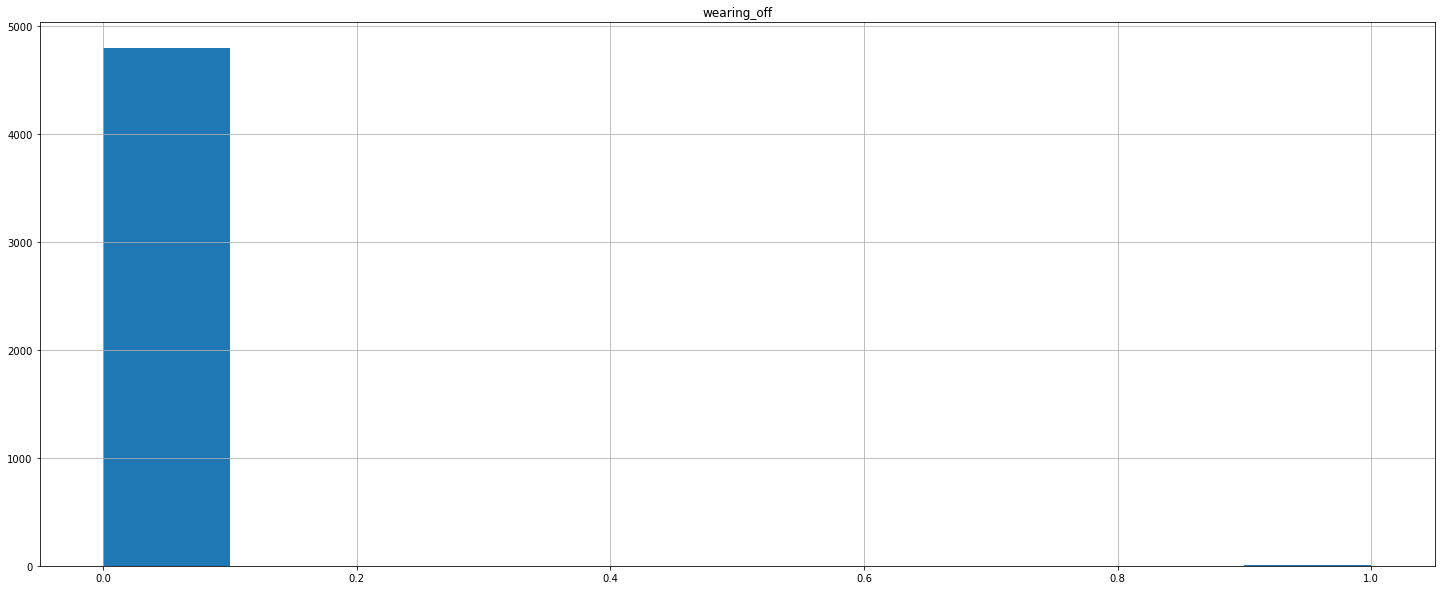

In [13]:
print(df[target_column].value_counts(normalize=False))
print(df[target_column].value_counts(normalize=True))
df.hist(column=target_column)

## Slice to get hourly data

In [14]:
if USE_HOURLY:
    # Slice [start:stop:step], starting from index 0, take every 4 record
    # Take every hour record only
    df = dataset[::SHIFT].copy() 

    # Fix columns arrangement
    dataset = dataset.reindex(columns=columns[1:])

    record_size_per_day = 24
    SHIFT = 1

## Split data

### Train-Test split

In [15]:
# training data 60% 
TRAINING_PERCENTAGE = 0.6
# validation data 20%
VALIDATION_PERCENTAGE = 0.2

column_indices = { name: i for i, name in enumerate(df.columns) }
total_rows = len(df)
num_features = len(df.columns)

training_end_index = int(total_rows * TRAINING_PERCENTAGE)
validation_end_index = int(total_rows * (TRAINING_PERCENTAGE + VALIDATION_PERCENTAGE))

train_df = df[0:training_end_index].copy()
validation_df = df[training_end_index:validation_end_index].copy()
test_df = df[validation_end_index:].copy()

print(f"Total data: {round(len(df)/record_size_per_day, 3)} days")
print( ( df.wearing_off.value_counts(normalize=True) * 100 ).round(3) )
print()
print(f"Training data: {round(len(train_df)/record_size_per_day, 3)} days")
print( ( train_df.wearing_off.value_counts(normalize=True) * 100 ).round(3) )
print()
print(f"Validation data: {round(len(validation_df)/record_size_per_day, 3)} days")
print( ( validation_df.wearing_off.value_counts(normalize=True) * 100 ).round(3) )
print()
print(f"Test data: {round(len(test_df)/record_size_per_day, 3)} days")
print( ( test_df.wearing_off.value_counts(normalize=True) * 100 ).round(3) )

Total data: 50.0 days
0    99.917
1     0.083
Name: wearing_off, dtype: float64

Training data: 30.0 days
0    99.861
1     0.139
Name: wearing_off, dtype: float64

Validation data: 10.0 days
0    100.0
Name: wearing_off, dtype: float64

Test data: 10.0 days
0    100.0
Name: wearing_off, dtype: float64


In [ ]:
# train_df, validation_df, test_df = split_train_validation_test_set(df, 
#                                                                    test_set_size=1, 
#                                                                    validation_percentage=0.2)

# print(f"Training data: {round(len(train_df)/record_size_per_day * 1, 3)} days")
# print(f"Validation data: {round(len(validation_df)/record_size_per_day * 1, 3)} days")
# print(f"Test data: {round(len(test_df)/record_size_per_day * 1, 3)} days")
# print(f"Total data: {round(len(df)/record_size_per_day * 1, 3)} days")

## Normalize data

In [ ]:
train_mean = train_df.loc[:, normalize_features].mean()
train_std = train_df.loc[:, normalize_features].std()

train_df = normalize_data(train_df, train_mean, train_std)
validation_df = normalize_data(validation_df, train_mean, train_std)
test_df = normalize_data(test_df, train_mean, train_std)

In [ ]:
df_standardized = (df.loc[:, normalize_features] - train_mean) / train_std
df_standardized = pd.merge(df_standardized, df.iloc[:, -2:], left_index=True,right_index=True)
df_standardized = df_standardized.melt(var_name='Columns', value_name='Normalized')
plt.figure()
ax = sns.violinplot(x='Columns', y='Normalized', data=df_standardized)
_ = ax.set_xticklabels(df.keys(), rotation=45)
plt.title("Distribution of normalized features")
if SAVEFIG:
    plt.savefig(f'./results/{user}_distribution_normalized_data.pdf')
plt.show()

In [ ]:
font = {'size': 30}
        # 'family' : 'normal',
        # 'weight' : 'bold',

mpl.rc('font', **font)

# Models

In [ ]:
validation_performance = {}
test_performance = {}

In [ ]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=SHIFT,
                                     train_df=train_df, test_df=test_df, validation_df=validation_df,
                                     label_columns=['wearing_off'])

In [ ]:
wide_single_step_window = WindowGenerator(input_width=record_size_per_day, label_width=record_size_per_day, shift=SHIFT,
                              train_df=train_df, validation_df=validation_df, test_df=test_df,
                              label_columns=['wearing_off'])

## Baseline model

In [ ]:
K.clear_session()
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None, name=None):
        super().__init__(name=name)
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['wearing_off'], name='Baseline')
baseline.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=METRICS)

In [ ]:
validation_performance[baseline.name] = baseline.evaluate(single_step_window.validation(remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP))
test_performance[baseline.name] = baseline.evaluate(single_step_window.test(remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=0)

In [ ]:
visualize_results(baseline, single_step_window, wide_single_step_window, 
                  history=None, savefig=SAVEFIG,
                  override=True,
                  remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
for name, value in zip(baseline.metrics_names, test_performance[baseline.name]):
  print(name, ': ', value)
print()

## Linear model

In [ ]:
K.clear_session()
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, activation="sigmoid", name="output")
], name = "Linear")

In [ ]:
history = compile_and_fit(linear, single_step_window,
                          remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
validation_performance[linear.name] = linear.evaluate(
    single_step_window.validation(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP))
test_performance[linear.name] = linear.evaluate(
    single_step_window.test(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=1,
    callbacks=[LossAndErrorPrintingCallback()])

In [ ]:
test_performance[linear.name] = linear.evaluate(
    single_step_window.test(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=0,
    callbacks=[LossAndErrorPrintingCallback()])

In [ ]:
visualize_results(linear, single_step_window, wide_single_step_window, 
                  history=history, savefig=SAVEFIG,
                  override=False,
                  remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
for name, value in zip(linear.metrics_names, test_performance[linear.name]):
  print(name, ': ', value)
print()

In [ ]:
m_bin = tf.keras.metrics.BinaryAccuracy()
m_bal = BalancedSparseCategoricalAccuracy()
m_auc = tf.keras.metrics.AUC()

y_trues = []
y_preds = []
for input, label in single_step_window.test(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP):
    y_true = label
    y_trues.append(y_true.numpy())
    print(f'Label: { [y_t for y_t in y_true.numpy().reshape(y_true.numpy().shape[0]) ]}')
    
    y_pred = linear(input)
    y_preds.append(y_pred.numpy())
    print(f'Predictions: {  [y_p for y_p in y_pred.numpy().reshape(y_pred.numpy().shape[0]) ]}')
    
    THRESHOLD = 0.5
    cm = confusion_matrix(y_true.numpy().reshape(y_true.shape[0]),
                          y_pred.numpy().reshape(y_pred.shape[0]) > THRESHOLD)
    print(cm)
    
    m_bin.update_state(y_true, y_pred)
    m_bal.update_state(y_true, y_pred)
    m_auc.update_state(y_true, y_pred)
    print(f'bin result: {m_bin.result().numpy()}')
    print(f'bal result: {m_bal.result().numpy()}')
    print(f'auc result: {m_auc.result().numpy()}')
    print()
    
# y_trues = np.concatenate(y_trues)
# y_preds = np.concatenate(y_preds)

### Feature Importance

In [ ]:
def plot_feature_importance(model):
    # if REMOVE_WEARING_OFF_IN_PREVIOUS_STEP:
    #     NUM_FEATURES = 14
    # else:
    NUM_FEATURES = 15
    
#     # use Kernel SHAP to explain test set predictions
#     explainer = shap.KernelExplainer(model, train_df.values)
#     shap_values = explainer.shap_values(test_df.values, nsamples=15)

#     # plot the SHAP values for the the first instance
#     shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test_df.iloc[0,:NUM_FEATURES], show=False, matplotlib=True)
#     plt.savefig(f'./results/feature_importance/{user}_shap_one_sample_{model.name}.pdf', bbox_inches='tight')
#     plt.show()

#     # TODO: OUTPUT OVERLAPPING
#     # shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], test_df.iloc[0,:NUM_FEATURES], show=False)
#     # plt.savefig(f'./results/{user}_shap_one_sample_{model.name}.pdf', bbox_inches='tight')
#     # plt.show()

#     # TODO: Convert HTML to PDF
#     f = shap.force_plot(explainer.expected_value[0], shap_values[0], test_df.iloc[:,:NUM_FEATURES], link="logit", show=False)
#     shap.save_html(f'./results/feature_importance/{user}_shap_stacked_samples_{model.name}.html', f)

#     # Summary Plot
#     f = plt.figure()
#     feature_names = [
#         a + ": " + str(b) for a,b in zip(test_df.columns, shap_values[0].mean(0).round(2))
#     ]
#     shap.summary_plot(shap_values[0], test_df, feature_names=feature_names)
#     f.savefig(f'./results/feature_importance/{user}_shap_summary_plot_{model.name}.pdf', bbox_inches='tight')

    # Native feature importance
    plt.bar(x = range(len(train_df.columns)),
            height=model.layers[0].kernel[:,0].numpy())
    axis = plt.gca()
    axis.set_xticks(range(len(train_df.columns)))
    _ = axis.set_xticklabels(train_df.columns, 
                             rotation=45, fontsize=18, ha='right')
    plt.title(f'Feature weights for Participant {user.replace("participant", "")} using {model.name} model')
    plt.savefig(f'./results/feature_importance/{user}_native_feature_importance_{model.name}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
plot_feature_importance(linear)

## Single-time-step Dense model

In [ ]:
K.clear_session()
single_time_step_dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid', name="output")
], name = "Single_time_step_Dense")

In [ ]:
history = compile_and_fit(single_time_step_dense, single_step_window,
                          remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
validation_performance[single_time_step_dense.name] = single_time_step_dense.evaluate(
    single_step_window.validation(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP))
test_performance[single_time_step_dense.name] = single_time_step_dense.evaluate(
    single_step_window.test(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=0)

In [ ]:
visualize_results(single_time_step_dense, single_step_window, wide_single_step_window,
                  history=history, savefig=SAVEFIG,
                  override=False,
                  remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
for name, value in zip(single_time_step_dense.metrics_names, test_performance[single_time_step_dense.name]):
  print(name, ': ', value)
print()

### Feature Importance

In [ ]:
plot_feature_importance(single_time_step_dense)

## Baseline model

In [ ]:
K.clear_session()
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None, name=None):
        super().__init__(name=name)
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, -1:, self.label_index]
        return result[:, :, tf.newaxis]

In [ ]:
baseline = Baseline(label_index=column_indices['wearing_off'], name='Baseline')
history = compile_and_fit(baseline, multi_step_window,
                         remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
validation_performance[baseline.name] = baseline.evaluate(multi_step_window.validation(remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP))
test_performance[baseline.name] = baseline.evaluate(multi_step_window.test(remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=0)

In [ ]:
plot_cm(baseline, multi_step_window, wide_multi_step_window,
                  history=history, savefig=SAVEFIG,
                  override=False,
                  remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
for name, value in zip(baseline.metrics_names, test_performance[baseline.name]):
  print(name, ': ', value)
print()

## Multi-time-step Dense model

In [ ]:
MULTI_STEP_WIDTH = record_size_per_day # t0, t1, t2, ..., t24
multi_step_window = WindowGenerator(input_width=MULTI_STEP_WIDTH, label_width=1, shift=SHIFT,
                                    train_df=train_df, validation_df=validation_df, test_df=test_df,
                                    label_columns=['wearing_off'])

In [ ]:
K.clear_session()
multi_time_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid', name="output"),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
], name = "Multi_time_step_Dense")

In [ ]:
history = compile_and_fit(multi_time_step_dense, multi_step_window,
                          remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
validation_performance[multi_time_step_dense.name] = multi_time_step_dense.evaluate(
    multi_step_window.validation(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP))
test_performance[multi_time_step_dense.name] = multi_time_step_dense.evaluate(
    multi_step_window.test(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=0)

In [ ]:
visualize_results(multi_time_step_dense, multi_step_window, multi_step_window,
                  history=history, savefig=SAVEFIG,
                  override=False,
                  remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
for name, value in zip(multi_time_step_dense.metrics_names, test_performance[multi_time_step_dense.name]):
  print(name, ': ', value)
print()

### Feature Importance

In [ ]:
# convert series to supervised learning
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    var_names = data.columns
    n_vars = len(var_names)
    df = DataFrame(data)
    cols, names = list(), list()    # new column values, new columne names
    
    # input sequence (t-i, ... t-1)
    # timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += list(
            map(lambda var_name: f'{var_name}(t-{i})', var_names)
        )
        
    # forecast sequence (t, t+1, ... t+n)
    # timesteps after (e.g., n_out = 3, t, t+1, t+2)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += list( map(lambda var_name: f'{var_name}(t)', var_names) )
        else:
            names += list( map(lambda var_name: f'{var_name}(t+{i})', var_names) )

    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [ ]:
# feature_weights = pd.DataFrame(multi_time_step_dense.layers[1].kernel[:,0].numpy()).T

# layer = single_time_step_dense.layers[0].kernel[:,0].numpy()
# width = 1
model = multi_time_step_dense

layer = multi_time_step_dense.layers[1].kernel[:,0].numpy()
width = MULTI_STEP_WIDTH

feature_weights = pd.DataFrame(layer).T
feature_weights.columns = list(series_to_supervised(train_df,
                                                    n_in=width, n_out=1
                                                   ).columns.drop([
                                                    'heart_rate(t)', 'steps(t)', 'stress_score(t)',
                                                    'awake(t)', 'deep(t)', 'light(t)', 'rem(t)',
                                                    'nonrem_total(t)', 'total(t)', 'nonrem_percentage(t)',
                                                    'sleep_efficiency(t)',
                                                    'timestamp_hour_sin(t)', 'timestamp_hour_cos(t)', 'timestamp_dayofweek(t)',
                                                    'wearing_off(t)']))


sorted_idx = feature_weights.values[0].argsort()
sorted_idx = np.concatenate([sorted_idx[0:10], sorted_idx[-10:]])
fig = plt.figure(figsize=(14, 7))
plt.barh(range(len(sorted_idx)), feature_weights.values[0][sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_weights.columns)[sorted_idx])
plt.ylabel('Features')
plt.xlabel('Weights')
plt.title('Feature Importance for participant %i' % 6)
plt.savefig(f'./results/feature_importance/{user}_native_feature_importance_{model.name}.pdf', bbox_inches='tight')
plt.show()

## CNN model

In [ ]:
MULTI_STEP_WIDTH = record_size_per_day # t0, t1, t2, ..., t24
multi_step_window = WindowGenerator(input_width=MULTI_STEP_WIDTH, label_width=1, shift=SHIFT,
                                    train_df=train_df, validation_df=validation_df, test_df=test_df,
                                    label_columns=['wearing_off'])

In [ ]:
LABEL_WIDTH = 4 * 6 # record_size_per_day
INPUT_WIDTH = LABEL_WIDTH + (MULTI_STEP_WIDTH - 1)
wide_multi_step_window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
                                         train_df=train_df, validation_df=validation_df, test_df=test_df,
                                         label_columns=['wearing_off'])

In [ ]:
K.clear_session()
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(MULTI_STEP_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid', name="output"),
], name = "CNN")

In [ ]:
history = compile_and_fit(cnn_model, multi_step_window,
                         remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
validation_performance[cnn_model.name] = cnn_model.evaluate(
    multi_step_window.validation(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP))
test_performance[cnn_model.name] = cnn_model.evaluate(
    multi_step_window.test(REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=0)

In [ ]:
# ORIGINAL: visualize_results(cnn_model, multi_step_window, wide_multi_step_window,
#  but not working
visualize_results(cnn_model, multi_step_window, wide_multi_step_window,
                  history=history, savefig=SAVEFIG,
                  override=False,
                  remove_target_column_from_input=REMOVE_WEARING_OFF_IN_PREVIOUS_STEP)

In [ ]:
for name, value in zip(cnn_model.metrics_names, test_performance[cnn_model.name]):
  print(name, ': ', value)
print()

### Feature importance

In [ ]:
feature_weights.values[0][sorted_idx]

In [ ]:
layer = cnn_model.layers[0].kernel.numpy().reshape(96*15, 64)
width = MULTI_STEP_WIDTH

feature_weights = pd.DataFrame(layer).T
feature_weights.columns = list(series_to_supervised(train_df,
                                                    n_in=width, n_out=1
                                                   ).columns.drop([
                                                    'heart_rate(t)', 'steps(t)', 'stress_score(t)',
                                                    'awake(t)', 'deep(t)', 'light(t)', 'rem(t)',
                                                    'nonrem_total(t)', 'total(t)', 'nonrem_percentage(t)',
                                                    'sleep_efficiency(t)',
                                                    'timestamp_hour_sin(t)', 'timestamp_hour_cos(t)', 'timestamp_dayofweek(t)',
                                                    'wearing_off(t)']))


sorted_idx = feature_weights.values[0].argsort()
sorted_idx = np.concatenate([sorted_idx[0:10], sorted_idx[-10:]])
fig = plt.figure(figsize=(14, 7))
plt.barh(range(len(sorted_idx)), feature_weights.values[0][sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_weights.columns)[sorted_idx])
plt.ylabel('Features')
plt.xlabel('Weights')
plt.title('Feature Importance for participant %i' % 6)
# plt.savefig(f'./results/feature_importance/{user}_native_feature_importance_{model.name}.pdf', bbox_inches='tight')
plt.show()

## LSTM model

In [ ]:
K.clear_session()
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1, activation='sigmoid', name="output")
], name = "LSTM")

In [ ]:
history = compile_and_fit(lstm_model, wide_single_step_window)

In [ ]:
validation_performance[lstm_model.name] = lstm_model.evaluate(
    wide_single_step_window.validation(not REMOVE_WEARING_OFF_IN_PREVIOUS_STEP))
test_performance[lstm_model.name] = lstm_model.evaluate(
    wide_single_step_window.test(not REMOVE_WEARING_OFF_IN_PREVIOUS_STEP), verbose=0)

In [ ]:
visualize_results(lstm_model, single_step_window, wide_single_step_window, 
                  history=history, override=not REMOVE_WEARING_OFF_IN_PREVIOUS_STEP,
                  savefig=SAVEFIG)

In [ ]:
for name, value in zip(lstm_model.metrics_names, test_performance[lstm_model.name]):
  print(name, ': ', value)
print()

# Performance

In [ ]:
FORMAT = 'png'

x = np.arange(len(test_performance))
width = 0.3

for metric_name in ['loss'] + list(map(lambda m: m.name, METRICS)):
    # metric_name = 'auc'
    metric_index = lstm_model.metrics_names.index(metric_name)
    validation_accuracy = [v[metric_index] for v in validation_performance.values()]
    test_accuracy = [v[metric_index] for v in test_performance.values()]

    plt.ylabel(f'{metric_name} [wearing_off, normalized]')
    plt.bar(x - 0.17, validation_accuracy, width, label='Validation')
    plt.bar(x + 0.17, test_accuracy, width, label='Test')
    plt.xticks(ticks=x, labels=test_performance.keys(),
               rotation=45)
    _ = plt.legend()
    plt.title(f'Test Performance ({metric_name.upper()}) for Participant {user.replace("participant", "")} on varying models')
    plt.savefig(f'./results/performance/test_performance_{user}_{metric_name}.{FORMAT}')
    plt.show()

In [ ]:
val_perf = pd.DataFrame(validation_performance,
             index = ['loss'] + list(map(lambda m: m.name, METRICS))
            )

In [ ]:
test_perf = pd.DataFrame(test_performance,
             index = ['loss'] + list(map(lambda m: m.name, METRICS))
            )

In [ ]:
val_perf['participant'] = user
val_perf['set'] = 'validation'

test_perf['participant'] = user
test_perf['set'] = 'test'

In [ ]:
final_performance = pd.concat([val_perf, test_perf])
final_performance

In [ ]:
final_performance = pd.concat([val_perf, test_perf])
if os.path.exists(f'./results/final_performance.xlsx'):
    with pd.ExcelWriter(f'./results/final_performance.xlsx', engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
        final_performance.to_excel(writer, startrow=writer.sheets['Sheet1'].max_row, header=None)
else:
    with pd.ExcelWriter(f'./results/final_performance.xlsx', engine='openpyxl', mode='w') as writer:
        final_performance.to_excel(writer)
final_performance